# Generosity Around the World

The primary objective of the model is to determine the extent to which certain socioeconomic factors influence the generosity of citizens of countries.

The datasets used are the 2018 and 2019 editions of the World Happiness Report conducted by Sustainable Development Solutions Network. 
https://www.kaggle.com/datasets/unsdsn/world-happiness

The data shows scores of six socioeconomic factors for each country in the world as determined through surveys of citizens in each country. These scores are then summed to create an overall “Happiness” score for each country, which then is used to rank each country by “Happiness.”

For this project, however, I wanted to have the dependent variable be the “Generosity” score rather than the “Happiness” score, as I was interested in determining factors that play into a country's generosity. I will be creating Linear Regression models that use backwards elimination, Polynomial Features, L1 regularization, L2 regularization, and Elastic Net to evaluate which best fits the data. Cross Validation will be used to ensure no overfitting has occured. Models will be evaluated using an $R^{2}$ score.

## Prelim

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings

In [2]:
data_2018 = pd.read_csv('Happiness_Index_2018.csv')
data_2019 = pd.read_csv('Happiness_Index_2019.csv')

## EDA and Data Transformation

In [3]:
data_full = pd.concat([data_2018, data_2019]).reset_index(drop=True)
data_full.columns

Index(['Overall rank', 'Country or region', 'Score', 'GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption'],
      dtype='object')

The features related to country name, happiness rank, and aggregate happiness score are of no use in the following models, and will therefore be removed.

In [4]:
data = data_full.drop(['Country or region', 'Overall rank', 'Score'], axis=1)
data.head()

,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1.305,1.592,0.874,0.681,0.202,0.393
1,1.456,1.582,0.861,0.686,0.286,0.340
2,1.351,1.590,0.868,0.683,0.284,0.408
3,1.343,1.644,0.914,0.677,0.353,0.138
4,1.420,1.549,0.927,0.660,0.256,0.357


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   GDP per capita                312 non-null    float64
 1   Social support                312 non-null    float64
 2   Healthy life expectancy       312 non-null    float64
 3   Freedom to make life choices  312 non-null    float64
 4   Generosity                    312 non-null    float64
 5   Perceptions of corruption     311 non-null    float64
dtypes: float64(6)
memory usage: 14.8 KB


All features are 'float64' data types, and therefore require no changes. There also appears to be one null value in 'Perceptions of corruption.'

### Remove NaNs

Below we remove the record that includes the null value.

In [6]:
print('Nulls Present?')
print(data.isnull().any())

Nulls Present?
GDP per capita                  False
Social support                  False
Healthy life expectancy         False
Freedom to make life choices    False
Generosity                      False
Perceptions of corruption        True
dtype: bool


Below we see there is one record with 'Perceptions of corruption' as a null value. As this is only one record of 312, we will entirely remove the record.

In [7]:
nans = data[data['Perceptions of corruption'].isnull()]
nanidx = nans.index
print(f'Count of Records with NaN: {nans.shape[0]}')


Count of Records with NaN: 1


In [8]:
data = data.drop(nanidx)

### Remove extreme values if necessary

In [9]:
data.describe()

,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
count,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000
mean,0.894447,1.212424,0.661267,0.423987,0.182916,0.111299
std,0.389311,0.299774,0.253131,0.156074,0.096895,0.095365
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.608000,1.057000,0.487500,0.325500,0.108500,0.050000
50%,0.960000,1.266000,0.700000,0.450000,0.175000,0.082000
75%,1.214500,1.458000,0.859000,0.540500,0.245000,0.140500
max,1.684000,1.644000,1.141000,0.724000,0.598000,0.457000


We see above all features have a minimum score of zeros. However, we will need to determine the extent to which we believe these zeros are  outliers or appropriate values given the range of each feature's distribution. We will use a box plot to visualize this.

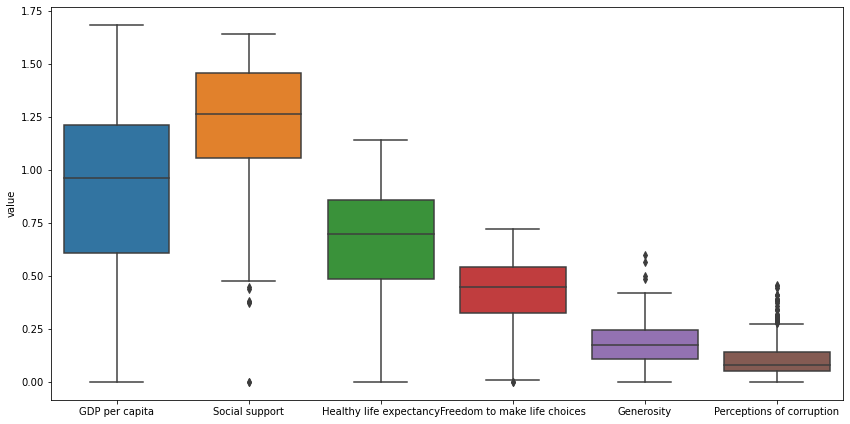

In [10]:
fig = plt.figure(figsize=(12,6))
box = sns.boxplot(x="variable", y="value", data=pd.melt(data))
box.set_xlabel('')
fig.tight_layout()

The box plot indicates the zeros for "Social support" are probably outliers that should be removed. All other variables show the zero values to be within or extremely close to the lower whisker, indicating it is probably correct data.

In [11]:
zeroidx = data[data['Social support'] == 0].index
data = data.drop(zeroidx)

data.describe()

,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,0.900074,1.220272,0.665175,0.425016,0.182634,0.111783
std,0.384196,0.284326,0.249187,0.156018,0.097143,0.095483
min,0.000000,0.372000,0.000000,0.000000,0.000000,0.000000
25%,0.619000,1.069000,0.495000,0.332000,0.108000,0.050000
50%,0.960000,1.268000,0.700000,0.450000,0.175000,0.082000
75%,1.219000,1.459000,0.861000,0.541000,0.245000,0.141000
max,1.684000,1.644000,1.141000,0.724000,0.598000,0.457000


### Evaluate histograms and correlation plots for each variable

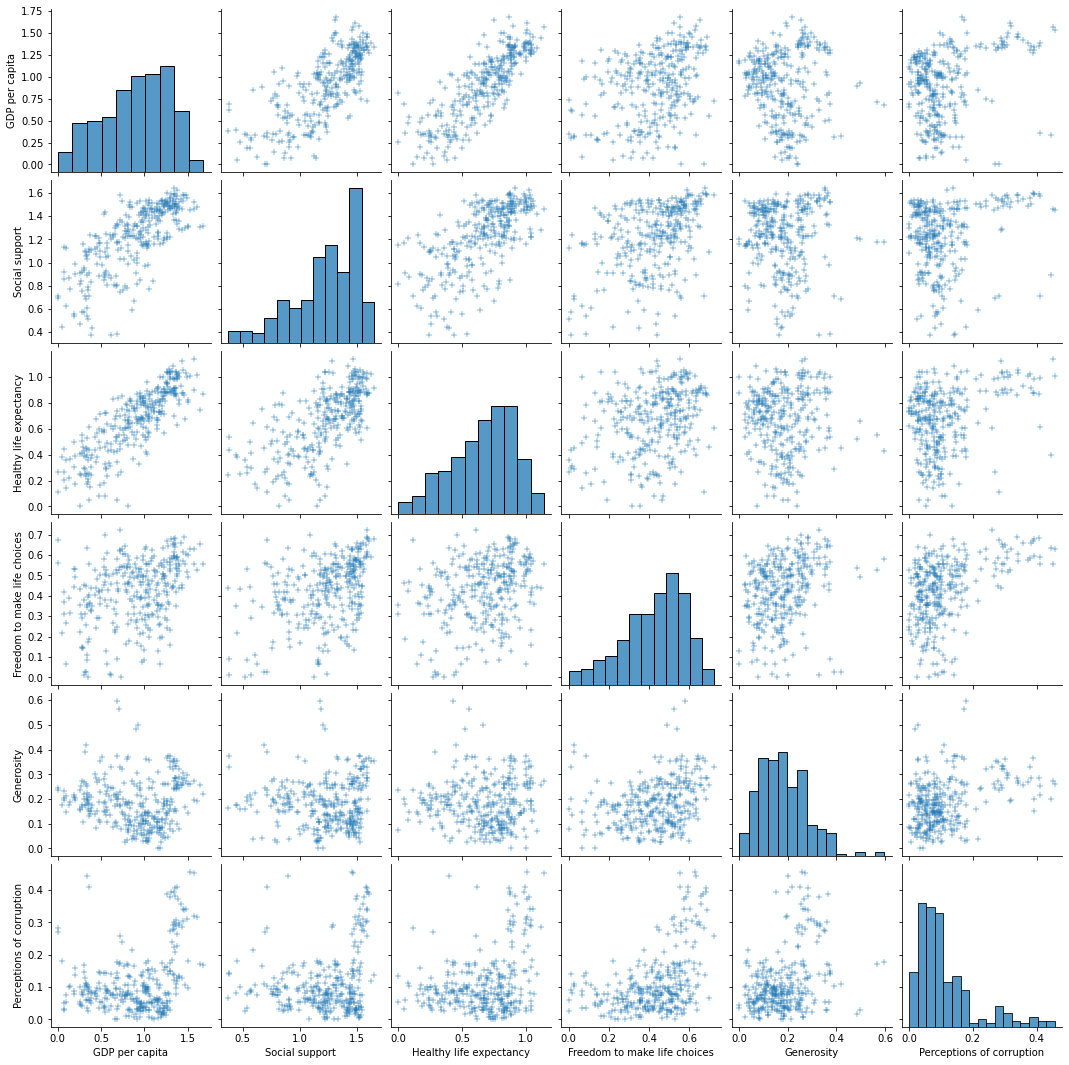

In [12]:
sns.pairplot(data, plot_kws=dict(marker="+"))

The pairplot above indicates all of the features have a noticable skew. As 'Generosity' will be our dependent $y$ variable, we will transform it using the Box-Cox method

In [13]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer('yeo-johnson')

gen = np.array(data['Generosity']).reshape(-1,1)
gen_bc = pt.fit_transform(gen)

Text(0.5, 0, 'Generosity (transformed)')

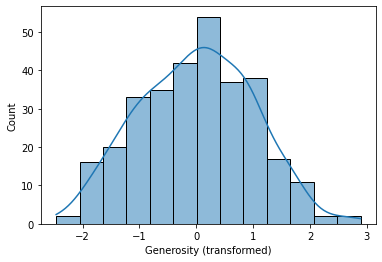

In [14]:
hist = sns.histplot(gen_bc, kde=True, legend=False)
hist.set_xlabel('Generosity (transformed)')

The histogram now shows a distribution that is closer to a standard normal distribution.

## Regression Methods

In [15]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
import statsmodels.api as sm

In [16]:
s = StandardScaler()
bc = PowerTransformer(method='box-cox', standardize=False)
lr = LinearRegression(fit_intercept=False)
las = Lasso(max_iter=100000)
ridge = Ridge()
pf = PolynomialFeatures()

In [17]:
X = data.drop('Generosity', axis=1)
X_s = pd.DataFrame(s.fit_transform(X), columns=X.columns)
y = gen_bc

### Method 1  - Linear Regression (Backwards elimination)

The first model will use a backwards elimination framework in which the feature with the lowest p-score will be removed from all subsequent iterations. Eliminations will stop once all remaining variables contain a p-value $\leq$ 0.05. 

In [19]:
ols = sm.OLS(y, X_s).fit()
print(ols.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.198
Model:                            OLS   Adj. R-squared (uncentered):              0.185
Method:                 Least Squares   F-statistic:                              15.03
Date:                Thu, 25 Aug 2022   Prob (F-statistic):                    3.40e-13
Time:                        07:14:11   Log-Likelihood:                         -404.31
No. Observations:                 309   AIC:                                      818.6
Df Residuals:                     304   BIC:                                      837.3
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [20]:
X2 = X_s.drop(['Social support'], axis=1)

In [21]:
ols = sm.OLS(y, X2).fit()
print(ols.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.198
Model:                            OLS   Adj. R-squared (uncentered):              0.188
Method:                 Least Squares   F-statistic:                              18.85
Date:                Thu, 25 Aug 2022   Prob (F-statistic):                    7.26e-14
Time:                        07:14:12   Log-Likelihood:                         -404.32
No. Observations:                 309   AIC:                                      816.6
Df Residuals:                     305   BIC:                                      831.6
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [22]:
X3 = X2.drop(['Healthy life expectancy'], axis=1)

In [23]:
ols = sm.OLS(y, X3).fit()
print(ols.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.195
Model:                            OLS   Adj. R-squared (uncentered):              0.187
Method:                 Least Squares   F-statistic:                              24.69
Date:                Thu, 25 Aug 2022   Prob (F-statistic):                    2.47e-14
Time:                        07:14:12   Log-Likelihood:                         -404.96
No. Observations:                 309   AIC:                                      815.9
Df Residuals:                     306   BIC:                                      827.1
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

After backwards elimination, we are left with three predictor features.

We will now use a k-folds cross validation to create predictions and evaluate the model.

In [24]:
kf = KFold(shuffle=True, random_state=531, n_splits=3)
lr_pred = cross_val_predict(estimator=lr, X=X3, y=y, cv=kf)
lr_pred = lr_pred.reshape(-1,1)

print(f'R\u00b2 Score: {r2_score(y, lr_pred)}')

R² Score: 0.18483577812492624


Text(0, 0.5, 'Generosity (Prediction)')

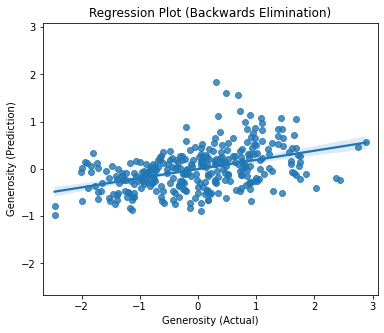

In [25]:
fig = plt.figure(figsize=(6,5))
reg = sns.regplot(x=y, y=lr_pred)
max = np.concatenate([y,lr_pred], axis=1).max()+0.2
min = np.concatenate([y,lr_pred], axis=1).min()-0.2
reg.set_xlim(min,max)
reg.set_ylim(min,max)
reg.set_title("Regression Plot (Backwards Elimination)")
reg.set_xlabel("Generosity (Actual)")
reg.set_ylabel("Generosity (Prediction)")

The $R^{2}$ of 0.185 is relatively low. We can hopefully improve upon this model in subsequent, more robust, models.

### (no backward elimination)

In [26]:
lr_pred_nbe = cross_val_predict(lr, X=X, y=y, cv=kf)
print(f'R\u00b2 Score: {r2_score(y, lr_pred_nbe)}')

R² Score: 0.15992731836979768


For the sake of comparison, if we did not eliminate any variables and use all of them, the $R^{2}$ would be 0.171. So backwards eliminationdid provide some improvement, albiet a small one.

### Method 2 - Linear Regression w/ Polynomial Features (no feature elimination)

The next model will dispense with the process of eliminating features, and instead will create new polynomial featuers. We will use a grid search to evaluate and cross validate polynomial features of degrees 2 and 3.

In [27]:
estimator_lr = Pipeline([("poly_features", pf),
                      ("scaler", s),
                      ("linear_regression", lr)])

params_lr = {"poly_features__degree": [2,3]}

grid_lr = GridSearchCV(estimator_lr, params_lr, cv=3)

grid_lr.fit(X, y)

print(f'Best Parameters: {grid_lr.best_params_}')

Best Parameters: {'poly_features__degree': 2}


The grid search indicates the best model will include features created with a polynomial degree of 1.

In [28]:
y_pred_lr = grid_lr.predict(X)
y_pred_lr = y_pred_lr.reshape(-1,1)
print(f'R\u00b2 Score: {r2_score(y, y_pred_lr)}')

R² Score: 0.3017324183512752


In [29]:
pf2 = PolynomialFeatures(2)
pf2.fit(X)
print(f'Feature count: {len(pf2.get_feature_names_out())}')

Feature count: 21


Text(0, 0.5, 'Generosity (Prediction)')

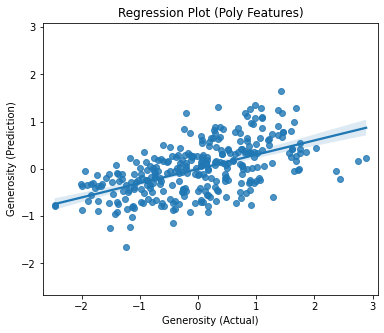

In [30]:
fig = plt.figure(figsize=(6,5))
reg = sns.regplot(x=y, y=y_pred_lr)
max = np.concatenate([y,y_pred_lr], axis=1).max()+0.2
min = np.concatenate([y,y_pred_lr], axis=1).min()-0.2
reg.set_xlim(min,max)
reg.set_ylim(min,max)
reg.set_title("Regression Plot (Poly Features)")
reg.set_xlabel("Generosity (Actual)")
reg.set_ylabel("Generosity (Prediction)")

This model, with an $R^{2}$ of 0.302 is a small improvement over the previous one.

### Method 3 - Lasso w/ Polynomial Features

The third model, as before, will evaluate different degrees of polynomial features. In addition, it will transform and eliminate features using L1 (or Lasso) regularization.

In [31]:
from sklearn.exceptions import ConvergenceWarning

In [32]:
X_las = data.drop('Generosity', axis=1)
y_las = gen_bc

We will, again, evaluate polynomial features of degree 1,2 and 3, and also evaluate ten different values for the $\lambda$ penalty term (called "alpha" in sklearn) between $10^{-9}$ and 1.

In [33]:
estimator = Pipeline([("poly_features", pf),
                      ("scaler", s),
                      ("lasso", las)])

params = {
    "poly_features__degree": [1,2,3],
    "lasso__alpha": np.geomspace(1e-9, 1, 10)
}

warnings.filterwarnings("ignore", category=ConvergenceWarning)
grid = GridSearchCV(estimator, params, cv=3)

grid.fit(X_las, y_las)

print(f'Best Parameters: {grid.best_params_}')

Best Parameters: {'lasso__alpha': 0.001, 'poly_features__degree': 3}


The grid search shows the best hyperparameters are $\lambda$=0.001 and polynomial features of degree 3.

In [34]:
y_pred = grid.predict(X_las)
y_pred = y_pred.reshape(-1,1)
print(f'R\u00b2 Score: {r2_score(y_las, y_pred)}')

R² Score: 0.37060285158953676


In [35]:
lass_coef = grid.best_estimator_.named_steps['lasso'].coef_
print(f'Feature count: {len(lass_coef[lass_coef !=0])}')

Feature count: 30


Text(0, 0.5, 'Generosity (Prediction)')

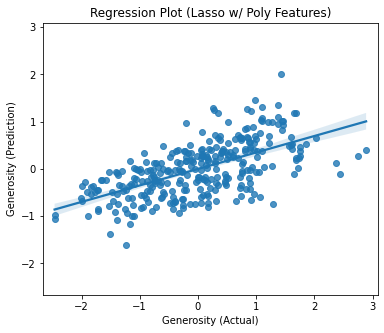

In [36]:
fig = plt.figure(figsize=(6,5))
reg = sns.regplot(x=y_las, y=y_pred)
max = np.concatenate([y_las,y_pred], axis=1).max()+0.2
min = np.concatenate([y_las,y_pred], axis=1).min()-0.2
reg.set_xlim(min,max)
reg.set_ylim(min,max)
reg.set_title("Regression Plot (Lasso w/ Poly Features)")
reg.set_xlabel("Generosity (Actual)")
reg.set_ylabel("Generosity (Prediction)")

We now see a larger improvement over the previous models with an ${R^2}$ score of 0.371

### Method 4 - Elastic Net w/ Polynomial Features

The final model we will build will use Elastic Net. This farmework will include both L1 and L2 regularization and contain a tunable hyperparameter that indicates the proportion of the regularization that uses L1.

In [37]:
from sklearn.linear_model import ElasticNet

In [38]:
en = ElasticNet(fit_intercept=False, max_iter=100000)

estimator_en = Pipeline([("poly_features", pf),
                      ("scaler", s),
                      ("elastic_net", en)])

params_en = {
    "poly_features__degree": [2,3],
    "elastic_net__alpha": np.geomspace(1e-9, 1, 10),
    "elastic_net__l1_ratio": np.linspace(0, 1, 11)
}

warnings.filterwarnings("ignore", category=ConvergenceWarning)
grid_en = GridSearchCV(estimator_en, params_en, cv=3)

grid_en.fit(X_las, y_las)

print(f'Best Parameters: {grid_en.best_params_}')


Best Parameters: {'elastic_net__alpha': 0.001, 'elastic_net__l1_ratio': 0.8, 'poly_features__degree': 3}


In [39]:
y_pred_en = grid_en.predict(X_las)
y_pred_en = y_pred_en.reshape(-1,1)
print(f'R\u00b2 Score: {r2_score(y_las, y_pred_en)}')

R² Score: 0.36964268933493905


In [40]:
en_coef = grid_en.best_estimator_.named_steps['elastic_net'].coef_
print(f'Feature count: {len(lass_coef[lass_coef !=0])}')

Feature count: 30


Text(0, 0.5, 'Generosity (Prediction)')

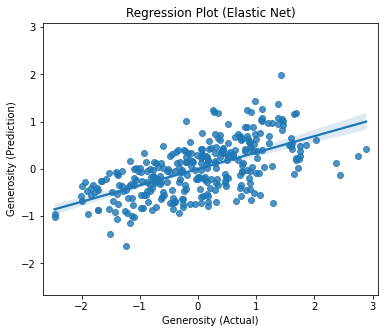

In [41]:
fig = plt.figure(figsize=(6,5))
reg = sns.regplot(x=y_las, y=y_pred_en)
max = np.concatenate([y_las,y_pred_en], axis=1).max()+0.2
min = np.concatenate([y_las,y_pred_en], axis=1).min()-0.2
reg.set_xlim(min,max)
reg.set_ylim(min,max)
reg.set_title("Regression Plot (Elastic Net)")
reg.set_xlabel("Generosity (Actual)")
reg.set_ylabel("Generosity (Prediction)")

This model achieved an $R^2$ score of 0.370, which is almost exactly the same as the previous model. This is not too surprising given that the 'alpha' and 'polynomial features' degree are the same as in the previous model. The only change is that this model is 80% L1 instead of 100% L1 in the previous model.

## Discussion of Results

Given that the last two model performed almost exactly the same, I had to choose one to further study the results. I chose the model that uses the full L1 regularization as opposed to the elastic net model that uses 80% L1.

We will now want to evaluate the coefficients of the individual ploynomial features to see what findings we can derive from the model. To do this, we need to take the absolute value of the coefficients in order to rank the features by the impact each has on our $y$ dependent variable.

In [42]:
pf3 = PolynomialFeatures(3)
pf3.fit(X_las)
pf3_names = np.array(pf3.get_feature_names_out())

lass_coefs_full = pd.DataFrame(zip(pf3_names, lass_coef))
lass_coefs_full[2] = abs(lass_coefs_full[1])
lass_coefs_sort = lass_coefs_full[lass_coefs_full[2] > 0].sort_values(by=2, axis=0, ascending=False)
lass_coefs_sort = lass_coefs_sort.rename(columns={0: "feature", 1: "coefficient", 2: "abs_value_coefficient"})

Below is a barplot created to show if there is an elbow point between more impactful and less impactful features.

<AxesSubplot:title={'center':'features sorted by coefficient abs value'}, xlabel='feature', ylabel='abs_value_coefficient'>

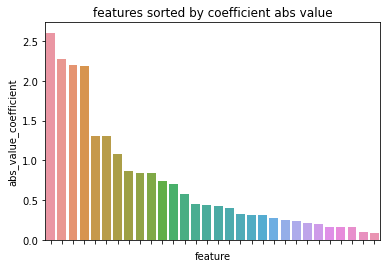

In [43]:
bar = sns.barplot(x='feature', y='abs_value_coefficient', data=lass_coefs_sort)
bar.set_title('features sorted by coefficient abs value')
bar.set_xticklabels([])
bar

The chart does show a noticable elbow point after the first four features, meaning that much information can be derived by looking only at the first four features. In addition, the next three features could be (and will be) used for additional context.

In [44]:
pd.set_option("display.max_colwidth", None)
print(lass_coefs_sort.iloc[:7,:2])
pd.set_option("display.max_colwidth", 50)

                                                   feature  coefficient
6                                         GDP per capita^2    -2.605657
20                             Perceptions of corruption^2     2.275179
23                GDP per capita^2 Healthy life expectancy     2.198194
19  Freedom to make life choices Perceptions of corruption    -2.183846
55                             Perceptions of corruption^3    -1.309235
21                                        GDP per capita^3     1.307589
13             Social support Freedom to make life choices     1.077853


'GDP per capita' and 'Perceptions of corruption' are present in almost all of the most impactful features, so it will be helpful to understand more about the polynomial relationships.

Text(0, 0.5, 'Generosity')

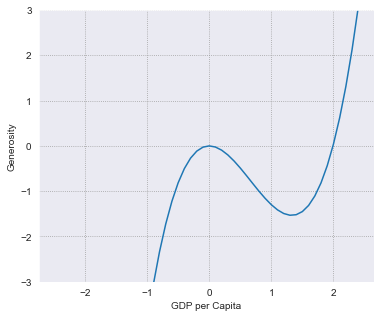

In [45]:
fig = plt.figure(figsize=(6,5))
gx = np.arange(-2.5, 2.5, 0.1)
gy = (1.307589*(gx**3))-(2.605657*(gx**2))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
gplot = sns.lineplot(x=gx,y=gy)
gplot.set_ylim(-3,3)
gplot.set_xlabel("GDP per Capita")
gplot.set_ylabel("Generosity")

This plot shows that when GDP per capita is below average, then generosity definitely decreases. However when GDP per capita is above average the relationship is less clear.

In addition, we see from the coefficients that 'GDP per capita'^2 x 'Healthy life expectancy' = 2.198194. This indicates that if 'Health life expectancy' is positively correlated with 'GDP per capita' then there is an even stronger positive relationship between 'GDP per capita' and 'Generosity.'

This intuitively makes sense that people are less generous in countries with weaker economies and less expectancy of a healthy life. 

Text(0, 0.5, 'Generosity')

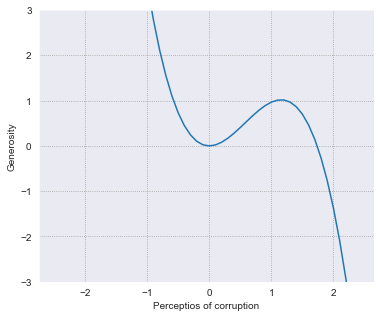

In [46]:
fig = plt.figure(figsize=(6,5))
px = np.arange(-2.5, 2.5, 0.1)
py = (2.275179*(px**2))-(1.309235*(px**3))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
pplot = sns.lineplot(x=px,y=py)
pplot.set_ylim(-3,3)
pplot.set_xlabel("Perceptios of corruption")
pplot.set_ylabel("Generosity")

This plot shows that when Perceptions of corruption is below average, then generosity increases. However when Perceptions of corruption is above average the relationship is less clear.

In addition, we see from the coefficients that 'Freedom to make life choices' x 'Perceptions of corruption' = -2.183846. This indicates that if 'Freedom to make life choices' is positively correlated with 'Perceptions of corruption' then there is an even stronger negative relationship between 'Perceptions of corruption' and 'Generosity.'

It intuitively makes sense that a decrease in the perceptions of corruption correlates to an increase in generosity. What is not intuitive is that a low degree of freedom to make life choices correlates with a high level of generosity when this freedom is coupled with a low perception of corruption. In other words, people may be more generous when under the rule of a benevolent dictator.

## Further areas of study

As shown above, there is an interesting relationship between 'Perceptions of corruption' and 'Freedom to make life choices.' This is an area that could be disected further.

We see from the models there is little accuracy in the model without adding polynomial features. However, polynomial features decrease the ability to interpret the model. Therefore, the model could be more robust and interpretable if polynomial features were kept at degree= 1 or 2 while adding additional features from other data sources. 